In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from datetime import datetime, date, timedelta
import time
import re
import itertools
from dotenv import load_dotenv

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc, fbeta_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

random_state = 55

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

## Get Dataset

In [2]:
FILE_NAME = "feature_frame.csv"
S3_DIR = "groceries/box_builder_dataset/"
BUCKET_NAME = "zrive-ds-data"
S3_PATH = "s3://" + BUCKET_NAME + S3_DIR + FILE_NAME
LOCAL_DATA_PATH = "../../data/"
LOCAL_FILE_PATH = LOCAL_DATA_PATH + FILE_NAME


def get_data_from_s3():
    """Download data from S3 if not exists locally."""
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

    if os.path.exists(LOCAL_FILE_PATH):
        print(f"File already exists at {LOCAL_FILE_PATH}")
        return

    try:
        s3 = boto3.client(
            "s3",
            aws_access_key_id=AWS_ACCESS_KEY_ID,
            aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
        )

        key = S3_DIR + FILE_NAME

        print(f"Downloading from {S3_PATH}")
        s3.download_file(BUCKET_NAME, key, LOCAL_FILE_PATH)
        print(f"File downloaded successfully to {LOCAL_FILE_PATH}")

    except Exception as e:
        print(f"Error downloading file: {e}")
        raise


# Download data if needed
get_data_from_s3()

# Load the dataset
df = pd.read_csv(LOCAL_FILE_PATH)

File already exists at ../../data/feature_frame.csv


## Filtering Data

We should only be focusing on purchases of at least 5 items, since it is a requirement coming from the sales team.

In [3]:
items_bought_per_order = (
    df[df["outcome"] == 1].groupby("order_id").size().reset_index(name="items_bought")
)
# row num diference between df and items_bought_per_order
df_with_count = df.merge(items_bought_per_order, on="order_id", how="left")
df_with_count["items_bought"].fillna(0, inplace=True)

sales_df = df_with_count[df_with_count["items_bought"] > 4]
print(
    f"Deleted items with less than 5 items bought: {len(df_with_count) - len(sales_df)}  ({(len(df_with_count) - len(sales_df))*100/len(df_with_count):.2f}%)"
)

Deleted items with less than 5 items bought: 716596  (24.88%)


## Data Split

I'll split the data in three subsets:
1. Train Data -> ~70%
2. Validation data -> ~20%
3. Test data -> ~10%

The key in most supervised learning is how we split the data. 
In this case: 
1. Mantain temporality, because the bussines may grow or evolve along the time, instead could be data leakage
2. I will not divide products in same order in different data splits, in order to avoid data leakage
3. I will make stratified sampling in order to preserve the target distribution

In [4]:
def temporal_split_data(
    df: pd.DataFrame,
    target_col: str = 'outcome',
    train_size: float = 0.7,
    val_size: float = 0.2,
    order_id_col: str = 'order_id',
    date_col: str = 'created_at'
) -> tuple:
    
    df_copy = df.copy()
    df_copy[date_col] = pd.to_datetime(df_copy[date_col])
    
    order_dates = df_copy.groupby(order_id_col)[date_col].min().reset_index()
    order_dates = order_dates.sort_values(date_col)
    
    total_orders = len(order_dates)
    train_orders = int(total_orders * train_size)
    val_orders = int(total_orders * val_size)
    
    train_orders_set = set(order_dates.iloc[:train_orders][order_id_col])
    val_orders_set = set(order_dates.iloc[train_orders:train_orders + val_orders][order_id_col])
    test_orders_set = set(order_dates.iloc[train_orders + val_orders:][order_id_col])
    
    train_mask = df_copy[order_id_col].isin(train_orders_set)
    val_mask = df_copy[order_id_col].isin(val_orders_set)
    test_mask = df_copy[order_id_col].isin(test_orders_set)
    
    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]
    
    X_train = X[train_mask].copy()
    X_val = X[val_mask].copy()
    X_test = X[test_mask].copy()
    
    y_train = y[train_mask].copy()
    y_val = y[val_mask].copy()
    y_test = y[test_mask].copy()
    
    train_cutoff_date = order_dates.iloc[train_orders - 1][date_col]
    val_cutoff_date = order_dates.iloc[train_orders + val_orders - 1][date_col]
    
    print(f"  Train ({len(X_train)/len(df)*100:.2f}%): {len(X_train):,} rows ({len(train_orders_set):,} orders)")
    print(f"  Val   ({len(X_val)/len(df)*100:.2f}%): {len(X_val):,} rows ({len(val_orders_set):,} orders)")
    print(f"  Test  ({len(X_test)/len(df)*100:.2f}%): {len(X_test):,} rows ({len(test_orders_set):,} orders)")
    
    print(f"  Train cutoff: {train_cutoff_date}")
    print(f"  Val cutoff:   {val_cutoff_date}")
    
    print(f"  Train: {y_train.value_counts(normalize=True).to_dict()}")
    print(f"  Val:   {y_val.value_counts(normalize=True).to_dict()}")
    print(f"  Test:  {y_test.value_counts(normalize=True).to_dict()}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = temporal_split_data(
    df=df,
    target_col='outcome'
)

  Train (66.93%): 1,927,962 rows (2,412 orders)
  Val   (21.55%): 620,646 rows (689 orders)
  Test  (11.52%): 331,941 rows (345 orders)
  Train cutoff: 2021-02-08 13:41:15
  Val cutoff:   2021-02-24 09:53:18
  Train: {0.0: 0.9877139694662032, 1.0: 0.012286030533796828}
  Val:   {0.0: 0.9897526126004196, 1.0: 0.010247387399580437}
  Test:  {0.0: 0.9904049213565062, 1.0: 0.009595078643493874}


## Evaluate Model

I'll use Fbeta score (with beta 0.3) givin more importance to precision over recall

In [5]:
def get_metrics(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    return fpr, tpr, roc_auc, precision, recall, pr_auc

In [6]:
def evaluate_linear_model(model, X_test, y_test, model_name="Model"):

    y_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, roc_auc, precision, recall, pr_auc = get_metrics(y_test, y_proba)
    
    return {
        'name': model_name,
        'y_proba': y_proba,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'pr_auc': pr_auc
    }

def plot_curves_comparison(results_list, title_suffix="", figsize=(15, 6)):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    
    for result in results_list:
        ax1.plot(result['fpr'], result['tpr'], 
                label=f"{result['name']} (AUC={result['roc_auc']:.2f})",
                linewidth=2)
    
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curves {title_suffix}')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    baseline_precision = results_list[0]['precision'].mean() if results_list else 0.5
    ax2.axhline(y=baseline_precision, color='k', linestyle='--', alpha=0.5, label='Baseline')
    
    for result in results_list:
        ax2.plot(result['recall'], result['precision'], 
                label=f"{result['name']} (AUC={result['pr_auc']:.2f})", 
                linewidth=2)
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall Curves {title_suffix}')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

## Baseline

To compare and justify our ML Models, we should always beat a baseline.

In this case, the `global_popularity` feature will be a good baseline to decide if the user will purchase or not

In [7]:
class PopularityBaseline:
        def __init__(self, threshold, popularity_col):
            self.threshold = threshold
            self.popularity_col = popularity_col
        
        def predict(self, X):
            return (X[self.popularity_col] >= self.threshold).astype(int)
        
        def predict_proba(self, X):
            proba_pos = X[self.popularity_col] / X[self.popularity_col].max()
            proba_neg = 1 - proba_pos
            return np.column_stack([proba_neg, proba_pos])
    
PopularityBaseline = PopularityBaseline(0.05, 'global_popularity')

## Building linear model

We have the dataset ready for sales team, now, we have to develop a machine learning model that, given a user and a product, predicts if the user would purchase. 

In [8]:
sales_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type', 'items_bought'],
      dtype='object')

So, we have to build a model to predict the 'outcome' feature given the other features:

- User info ->    ```user_order_seq```, ```count_adults```, ```count_children```, ```count_babies```, ```count_pets```, ```people_ex_baby```
- Product info -> ```product_type```, ```normalised_price```, ```discount_pct```, ```vendor```, ```global_popularity```
- Product-User info -> ```ordered_before```, ```abandoned_before```, ```active_snoozed```, ```set_as_regular``` and those related with days since...
- Target -> ```outcome```

What happens with other variables? 

- IDs -> Don`t give numeric information, delete it (```order_id``` will be important to split data, but then, delete it)
- Items_bought -> We won´t have that info in production


We still have 2 variables left: 
1. ```created_at```: In production will be the current date. I will preprocess it and get day num, month num and week num.
2. ```order_date```: Redundant, delete it. 


In [9]:
target = "outcome"
cols_to_drop = ["variant_id", "user_id", "order_date", "items_bought"]
order_id_col = "order_id"

feature_cols = sales_df.columns[~sales_df.columns.isin(cols_to_drop + [target])]
feature_cols

Index(['product_type', 'order_id', 'created_at', 'user_order_seq',
       'ordered_before', 'abandoned_before', 'active_snoozed',
       'set_as_regular', 'normalised_price', 'discount_pct', 'vendor',
       'global_popularity', 'count_adults', 'count_children', 'count_babies',
       'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

Now, we are going to try with differents models, iteratively, so first models only will have binary and numeric columns

In [10]:
numeric_cols = sales_df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('order_id')
categorical_cols = sales_df[feature_cols].select_dtypes(exclude=[np.number]).columns.tolist()

In [11]:
def create_numeric_logistic_pipelines():
    
    pipelines = {}
    
    pipelines['No Penalty'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(penalty=None, max_iter=1000, random_state=random_state))
    ])
    
    C_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    
    for C in C_values:
        pipelines[f'L1 (C={C})'] = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(penalty='l1', C=C, solver='liblinear', 
                                       max_iter=1000, random_state=random_state))
        ])
    
    for C in C_values:
        pipelines[f'L2 (C={C})'] = Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(penalty='l2', C=C, max_iter=1000, 
                                       random_state=random_state))
        ])
    
    return pipelines

We are goint to compare how regularization performs in this dataset, comparing ridge and lasso

   Training No Penalty...
   Training L1 (C=1e-06)...
   Training L1 (C=1e-05)...
   Training L1 (C=0.0001)...
   Training L1 (C=0.001)...
   Training L1 (C=0.01)...
   Training L1 (C=0.1)...
   Training L2 (C=1e-06)...
   Training L2 (C=1e-05)...
   Training L2 (C=0.0001)...
   Training L2 (C=0.001)...
   Training L2 (C=0.01)...
   Training L2 (C=0.1)...
   ✅ All models trained


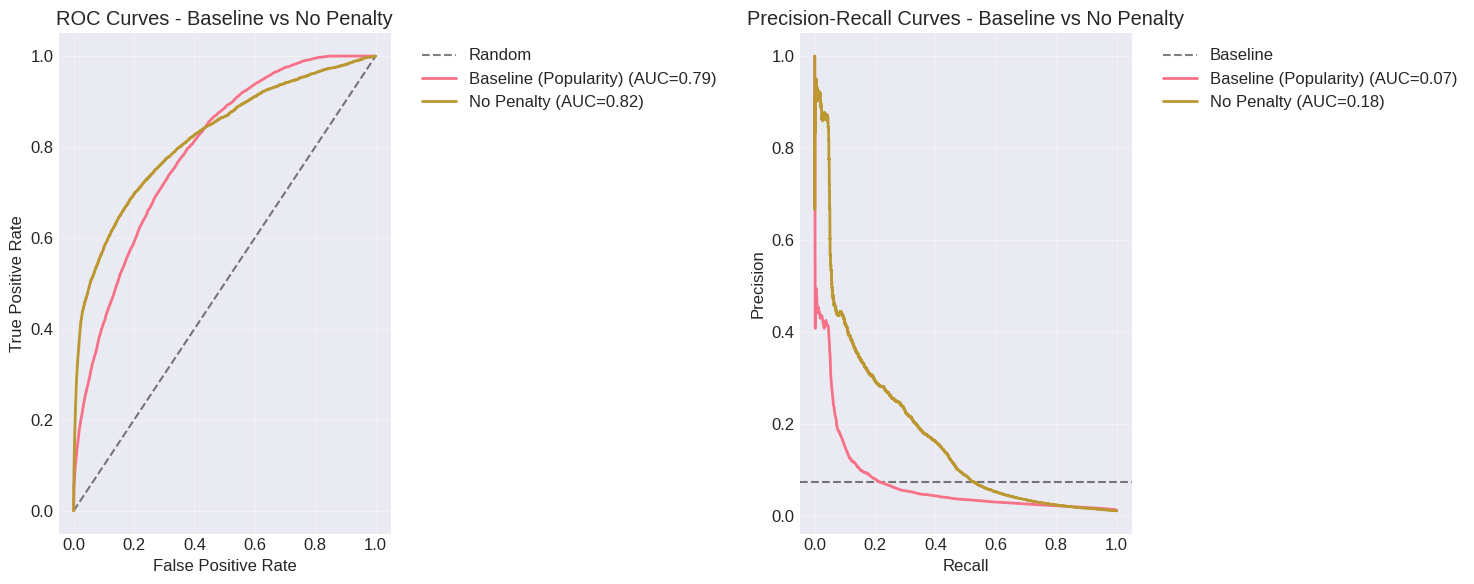

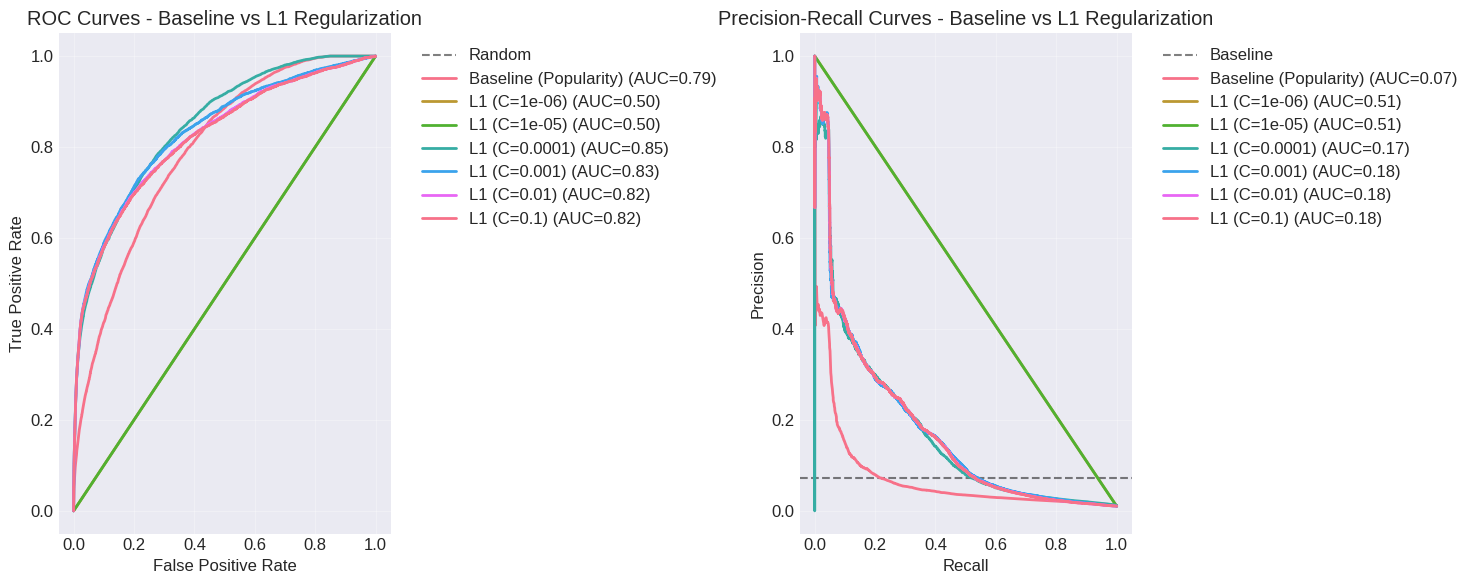

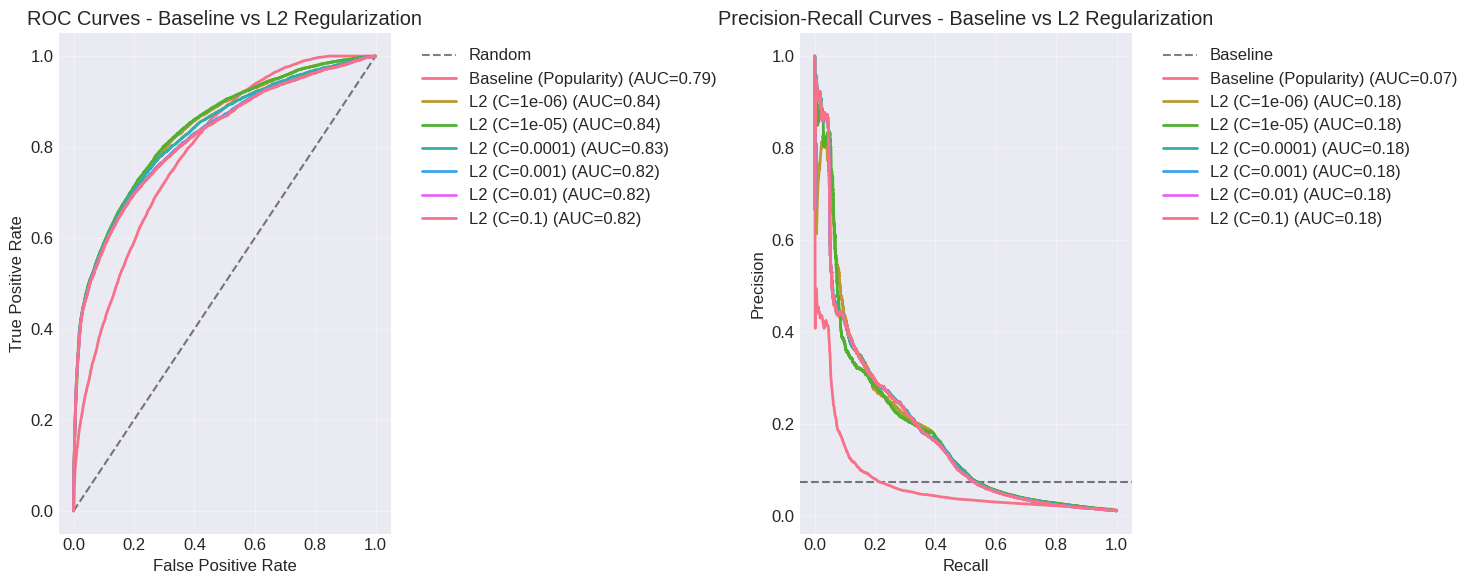

In [12]:

X_train_num = X_train[numeric_cols].copy()
X_val_num = X_val[numeric_cols].copy() 
X_test_num = X_test[numeric_cols].copy()

pipelines = create_numeric_logistic_pipelines()

trained_models = {}
for name, pipeline in pipelines.items():
    print(f"   Training {name}...")
    pipeline.fit(X_train_num, y_train)
    trained_models[name] = pipeline

print("   ✅ All models trained")

all_results = []
baseline_result = evaluate_linear_model(PopularityBaseline, X_val_num, y_val, "Baseline (Popularity)")
all_results.append(baseline_result)

for name, model in trained_models.items():
    result = evaluate_linear_model(model, X_val_num, y_val, name)
    all_results.append(result)

baseline_results = [r for r in all_results if 'Baseline' in r['name'] or 'No Penalty' in r['name']]
l1_results = [r for r in all_results if 'Baseline' in r['name'] or 'L1' in r['name']]
l2_results = [r for r in all_results if 'Baseline' in r['name'] or 'L2' in r['name']]

fig1 = plot_curves_comparison(baseline_results, "- Baseline vs No Penalty")
plt.show()

fig2 = plot_curves_comparison(l1_results, "- Baseline vs L1 Regularization")
plt.show()

fig3 = plot_curves_comparison(l2_results, "- Baseline vs L2 Regularization")
plt.show()

The baseline is beated by far. Regularization improves the performance but there isn't so much diference. These are slighly best models:
1. `L1 (C=0.0001)`
2. `L2 (C=1e-05)`

Let's see how regularization is affecting the parameters

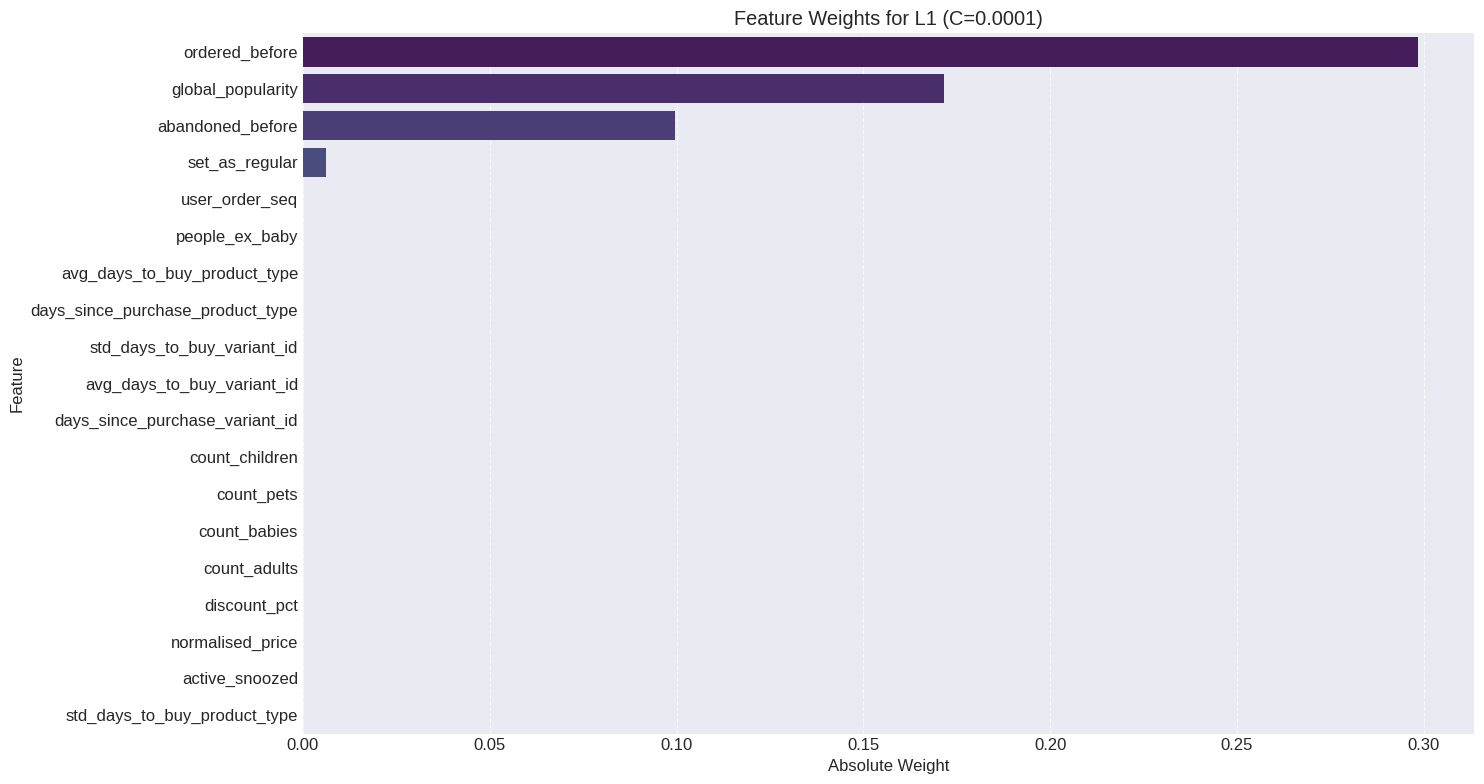

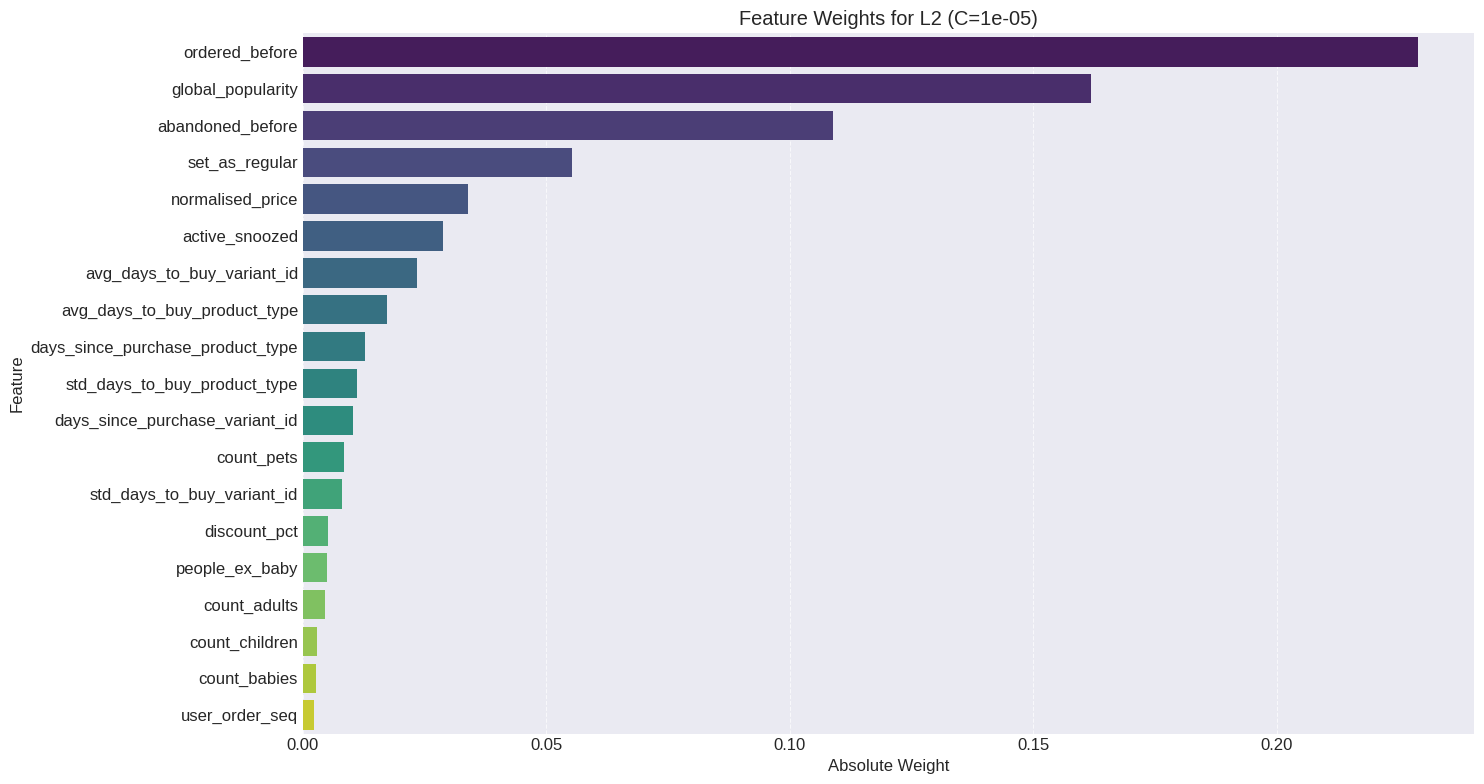

In [13]:
def plot_model_weights(model, columns, figsize=(15, 8), model_name=None):            
    if type(model) is Pipeline:
        try:
            model = model.named_steps['model']
        except KeyError:
            raise ValueError("Pipeline does not contain a step named 'model'. Please check the pipeline structure.")
             
    if type(model) is LogisticRegression:
        coefs = model.coef_[0]
                 
        weights_df = pd.DataFrame({
            'Feature': columns,
            'Weight': np.abs(coefs),
        })
     
    if type(model) is DecisionTreeClassifier or type(model) is LGBMClassifier:
        coefs = model.feature_importances_
         
        weights_df = pd.DataFrame({
            'Feature': columns,
            'Weight': coefs,
        })
         
    weights_df = weights_df.sort_values('Weight', ascending=False)
         
    plt.figure(figsize=figsize)
    sns.barplot(x='Weight', y='Feature', data=weights_df, palette='viridis')
    plt.title(f'Feature Weights for {model_name or "Model"}')
    plt.xlabel('Absolute Weight')
    plt.ylabel('Feature')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

model1_name = 'L1 (C=0.0001)'
model2_name = 'L2 (C=1e-05)'
model1 = trained_models[model1_name]
model2 = trained_models[model2_name]

plot_model_weights(model1, numeric_cols, model_name=model1_name)
plot_model_weights(model2, numeric_cols, model_name=model2_name)

We can se that features `ordered_before`, `global_popularity`, `abandoned_before` and `set_as_regular` are the most importants. So we are going to remove the other ones

In [14]:
baseline_cols = [
    'ordered_before',
    'global_popularity',
    'abandoned_before',
    'set_as_regular'
]

### Add `created_at` feature

Now, i'll try adding the categorical `created_at` feature, but first i'll preproces it:

```created_at``` feature has this type: **'2020-02-05 16:46:19'**

That isn´t a numeric value, so I will create 2 features from that date:
1. ```year``` (2020)
4. ```doy``` day of the year (36)

In [15]:
class DateFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_column="created_at"):
        self.date_column = date_column
        self.date_feature_names = ["year", "doy"]

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        Xc = X.copy()

        dates = pd.to_datetime(Xc[self.date_column], errors="coerce")

        Xc["year"] = dates.dt.year.astype("int16")
        Xc["doy"]  = dates.dt.dayofyear.astype("int16")

        return Xc.drop(columns=[self.date_column])

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(
            [f for f in input_features if f != self.date_column] + self.date_feature_names
        )


### Categorical Encoders

Also, I'll try with Frecuency encoders and Target Encoder on `vendor` and `product_type` features

In [16]:
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_columns=['vendor', 'product_type'], dtype="float32", unknown_strategy="min"):
        self.categorical_columns = categorical_columns
        self.dtype = dtype
        self.unknown_strategy = unknown_strategy
        self.frequency_maps_: dict[str, pd.Series] = {}
        self.default_: dict[str, float] = {}

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()

        for col in self.categorical_columns:
            if col not in X.columns:
                continue

            s = X[col].astype("category")
            freq = s.value_counts(normalize=True)

            self.frequency_maps_[col] = freq.astype(self.dtype)

            if self.unknown_strategy == "min":
                self.default_[col] = freq.min()
            elif self.unknown_strategy == "zero":
                self.default_[col] = 0.0
            else:  # user supplied literal
                self.default_[col] = float(self.unknown_strategy)

        return self

    def transform(self, X):
        Xc = X.copy(deep=False)

        for col, fmap in self.frequency_maps_.items():
            if col not in Xc.columns:
                continue

            Xc[col] = (
                Xc[col]
                .map(fmap)                               
                .fillna(self.default_[col])              
                .astype(self.dtype, copy=False)          
            )

        return Xc

    def get_feature_names_out(self, input_features=None):
        return (
            np.array(input_features)
            if input_features is not None
            else np.array(self.feature_names_in_)
        )


class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        categorical_columns=['vendor', 'product_type'],
        target_column="outcome",
        min_samples_leaf=1,
        smoothing=1.0,
    ):
        self.categorical_columns = categorical_columns
        self.target_column = target_column
        self.min_samples_leaf = min_samples_leaf
        self.smoothing = smoothing
        self.target_means = {}
        self.global_mean = 0

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist()

        self.global_mean = y.mean()

        if len(X) != len(y):
            raise ValueError("X and y must have the same number of rows")

        for column in self.categorical_columns:
            if column in X.columns:
                temp_df = pd.DataFrame({
                    'category': X[column],
                    'target': y
                })
                agg_df = temp_df.groupby('category').agg({
                    'target': ['count', 'mean']
                })
                agg_df.columns = ['count', 'mean']
                agg_df['smooth_mean'] = (
                    (agg_df['count'] * agg_df['mean'] + self.smoothing * self.global_mean) /
                    (agg_df['count'] + self.smoothing)
                )

                self.target_means[column] = agg_df['smooth_mean'].to_dict()

        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for column in self.categorical_columns:
            if column in X_copy.columns:
                X_copy[column] = X_copy[column].map(
                    lambda x: self.target_means[column].get(x, self.global_mean)
                )
        
        return X_copy
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        
        return np.array(input_features)

In [17]:
def create_column_transformer(
    numeric_cols=numeric_cols, scale_numericals=True, categorical_cols=['vendor', 'product_type'], date_col="created_at",
    categorical_transformer=None,
):
    transformers = []

    if numeric_cols:
        if scale_numericals:
            transformers.append(
                ("numeric", StandardScaler(), numeric_cols)
            )
        else:
            transformers.append(
                ("numeric", "passthrough", numeric_cols)
            )

    if categorical_cols:
        transformers.append(
            ("categorical", categorical_transformer, categorical_cols)
        )

    if date_col:
        transformers.append(
            ("date", DateFeatureTransformer(), [date_col])
        )

    return ColumnTransformer(transformers, remainder="drop")

In [18]:
def create_categorical_pipeline(encoder_type='frequency', penalty='l1', C=0.0001):
    
    if encoder_type == 'frequency':
        categorical_transformer = FrequencyEncoder()
    elif encoder_type == 'target':
        categorical_transformer = TargetEncoder()
    else:
        raise ValueError("encoder_type must be 'frequency' or 'target'")
    
    preprocessor = create_column_transformer(
        numeric_cols=baseline_cols,
        categorical_transformer=categorical_transformer
    )
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(
            penalty=penalty, C=C, solver='liblinear', 
            max_iter=1000, random_state=random_state
        ))
    ])
    
    return pipeline

categorical_pipelines = {
    'Frequency Encoder': create_categorical_pipeline('frequency', 'l1', 0.0001),
    'Target Encoder': create_categorical_pipeline('target', 'l1', 0.0001)
}

X_train_cat = X_train[baseline_cols + categorical_cols].copy()
X_val_cat = X_val[baseline_cols + categorical_cols].copy()
X_test_cat = X_test[baseline_cols + categorical_cols].copy()

trained_categorical_models = {}
for name, pipeline in categorical_pipelines.items():
    print(f"   Training {name}...")
    pipeline.fit(X_train_cat, y_train)
    trained_categorical_models[name] = pipeline


   Training Frequency Encoder...
   Training Target Encoder...


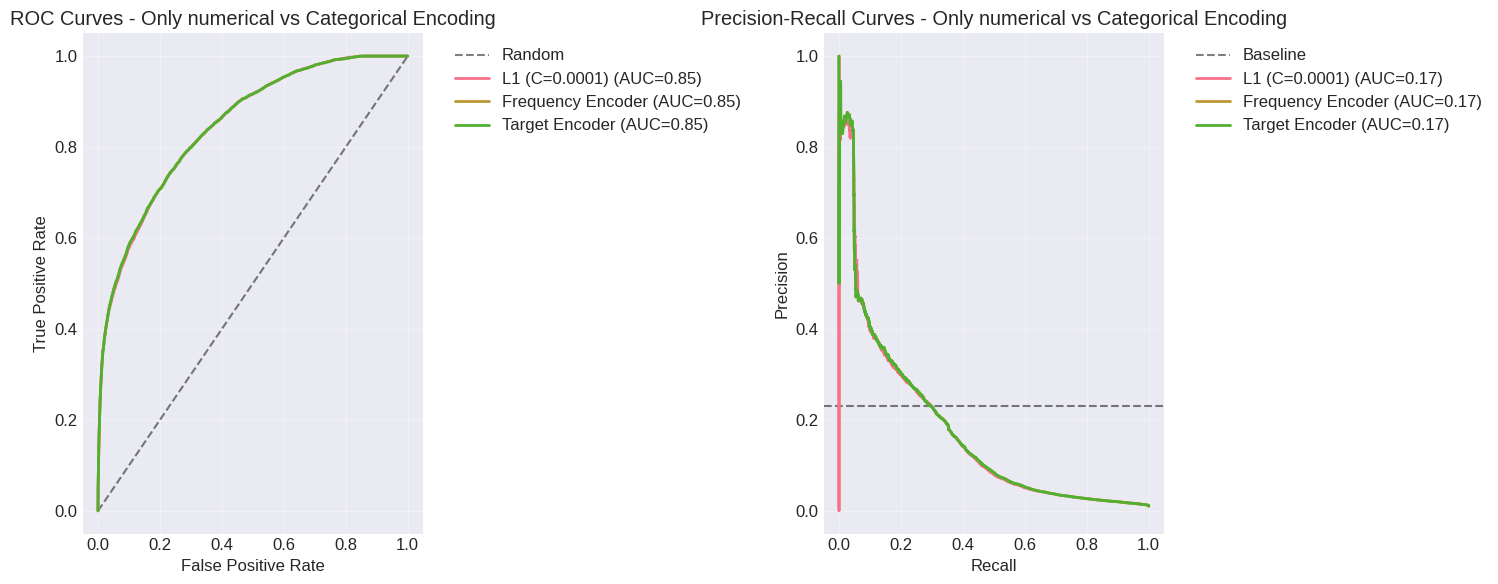

In [19]:
categorical_results = []

best_only_numercial_result = [r for r in all_results if 'L1 (C=0.0001)' in r['name']][0]
categorical_results.append(best_only_numercial_result)

for name, model in trained_categorical_models.items():
    result = evaluate_linear_model(model, X_val_cat, y_val, name)
    categorical_results.append(result)

fig1 = plot_curves_comparison(
    categorical_results, 
    "- Only numerical vs Categorical Encoding"
)
plt.show()

They haven't improved the AUC. So this is our best linear model

In [20]:
baseline_cols = [
    'global_popularity',
    'ordered_before',
    'abandoned_before',
    'set_as_regular'
]
preprocessor = create_column_transformer(
        numeric_cols=baseline_cols,
        categorical_cols=None,  # No categorical columns for this pipeline
        date_col=None,  # No date column for this pipeline
    )

linear_baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(
        penalty='l1', C=0.0001, solver='liblinear', 
        max_iter=1000, random_state=random_state
    ))
])

linear_baseline_pipeline.fit(X_train, y_train)

result = evaluate_linear_model(
    linear_baseline_pipeline, 
    X_val, 
    y_val, 
    model_name="Linear Baseline"
)
print(f"Linear Baseline ROC AUC: {result['roc_auc']:.4f}")
print(f"Linear Baseline PR AUC: {result['pr_auc']:.4f}")

Linear Baseline ROC AUC: 0.8472
Linear Baseline PR AUC: 0.1728


# Non-Linear Models

I`ve explored linear models, but actualy there aren't best models to fit most data, non linear models have fits better to data

## Decision Trees

In [21]:
def predict_with_threshold(model: BaseEstimator,
                           X, threshold: float = 0.5
    ) -> np.ndarray:

    y_prob = model.predict_proba(X)[:, 1]
    return (y_prob >= threshold).astype(int)


def find_best_threshold_fbeta(y_true, y_prob, beta=0.3):

    precision, recall, thr = precision_recall_curve(y_true, y_prob)
    f_beta = ((1 + beta**2) * precision * recall) / (
             beta**2 * precision + recall + 1e-12)
    best_idx = np.argmax(f_beta)
    return thr[best_idx], f_beta[best_idx]

def fit_and_evaluate_pipeline(
        pipeline, X_train, y_train, X_val, y_val, threshold=None
    ):
    
    t0 = time.time()
    pipeline.fit(X_train, y_train)
    print(f"   ⌛ Fitted in {time.time()-t0:.2f}s")

    y_val_prob   = pipeline.predict_proba(X_val)[:, 1]

    fpr, tpr, roc_auc, precision, recall, pr_auc = get_metrics(y_val, y_val_prob)

    if not threshold:
        best_thr, f_beta_val = find_best_threshold_fbeta(y_val, y_val_prob)
    else:
        best_thr = threshold
        f_beta_val = fbeta_score(y_val, (y_val_prob >= best_thr).astype(int), beta=0.3)


    print(f"   🎯 ROC_AUC : {roc_auc:.4f}")
    print(f"   🎯 PR_AUC  : {pr_auc:.4f}")
    print(f"   🎯 F-beta  : {f_beta_val:.4f} (threshold={best_thr:.4f})")

    return pipeline, roc_auc, pr_auc, f_beta_val, best_thr

### Hyperparameter Grid Search for Decision Tree
Now we'll test different hyperparameter combinations with all the features, because a non-linar model should fit better. Then we will see the features importance

In [ ]:
def create_tree_param_grid(base_params, max_iterations):
    
    all_combinations = list(ParameterGrid(base_params))
    
    valid_combinations = []
    for params in all_combinations:
        if params['min_samples_leaf'] <= params['min_samples_split'] // 2:
            valid_combinations.append(params)
    
    if max_iterations and len(valid_combinations) > max_iterations:
        selected = []
        for max_depth in base_params['max_depth']:
            depth_combos = [c for c in valid_combinations if c['max_depth'] == max_depth]
            if depth_combos and len(selected) < max_iterations:
                selected.extend(depth_combos[:max_iterations//4 + 1])
        valid_combinations = selected[:max_iterations]
    
    return valid_combinations

def run_tree_grid_search(X_train, y_train, X_val, y_val, features, base_params, max_iterations):
    
    param_combinations = create_tree_param_grid(base_params, max_iterations)
    
    results = []
    
    for i, params in enumerate(param_combinations, 1):
        print(f"--TRIAL {i}:")
        print(f"  max_depth={params['max_depth']}, criterion={params['criterion']}")
        print(f"  min_samples_split={params['min_samples_split']}, min_samples_leaf={params['min_samples_leaf']}")

        encoder = FrequencyEncoder(['vendor', 'product_type'])
        preprocessor = create_column_transformer(
            scale_numericals=False, categorical_transformer=encoder
        )
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', DecisionTreeClassifier(
                max_depth=params['max_depth'],
                criterion=params['criterion'],
                min_samples_split=params['min_samples_split'],
                min_samples_leaf=params['min_samples_leaf'],
                random_state=random_state
            ))
        ])
        
        pipeline, roc_auc, pr_auc, f_beta_val, best_threshold = fit_and_evaluate_pipeline(
            pipeline, X_train, y_train, X_val, y_val
        )
                
        result = {
            'config_id': i,
            'max_depth': params['max_depth'],
            'criterion': params['criterion'],
            'min_samples_split': params['min_samples_split'],
            'min_samples_leaf': params['min_samples_leaf'],
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'f03_val': f_beta_val,
            'threshold': best_threshold,
            'pipeline': pipeline
        }
        results.append(result)
    
    results_df = pd.DataFrame(results)
    
    return results_df

base_params = {
    'max_depth': [3, 6, 10, 15],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2000, 500, 100, 50],
    'min_samples_leaf': [300, 100, 75, 40, 5]
}

grid_results = run_tree_grid_search(
    X_train[numeric_cols + ['vendor', 'product_type', 'created_at']], y_train, X_val[numeric_cols + ['vendor', 'product_type', 'created_at']], y_val, 
    baseline_cols, base_params,
    max_iterations=100
)

--TRIAL 1:
  max_depth=3, criterion=gini
  min_samples_split=2000, min_samples_leaf=300
   ⌛ Fitted in 3.02s
   🎯 ROC_AUC : 0.7610
   🎯 PR_AUC  : 0.2183
   🎯 F-beta  : 0.3914 (threshold=0.7731)
--TRIAL 2:
  max_depth=3, criterion=gini
  min_samples_split=2000, min_samples_leaf=100
   ⌛ Fitted in 2.92s
   🎯 ROC_AUC : 0.7610
   🎯 PR_AUC  : 0.2183
   🎯 F-beta  : 0.3914 (threshold=0.7731)
--TRIAL 3:
  max_depth=3, criterion=gini
  min_samples_split=500, min_samples_leaf=100
   ⌛ Fitted in 2.66s
   🎯 ROC_AUC : 0.7610
   🎯 PR_AUC  : 0.2192
   🎯 F-beta  : 0.3914 (threshold=0.5579)
--TRIAL 4:
  max_depth=3, criterion=gini
  min_samples_split=2000, min_samples_leaf=75
   ⌛ Fitted in 2.80s
   🎯 ROC_AUC : 0.7610
   🎯 PR_AUC  : 0.2183
   🎯 F-beta  : 0.3914 (threshold=0.7731)
--TRIAL 5:
  max_depth=3, criterion=gini
  min_samples_split=500, min_samples_leaf=75
   ⌛ Fitted in 2.68s
   🎯 ROC_AUC : 0.7610
   🎯 PR_AUC  : 0.2191
   🎯 F-beta  : 0.3914 (threshold=0.5579)
--TRIAL 6:
  max_depth=3, criterio

Wich one is best?

I prefer those models with PR AUC high, instead of those models with f03 score high. We aren't in a scenario with f_beta_score constraint, so I prefer models that generaly work well with any threshold, and then choose the threshold with best f_beta_score

In [22]:
all_features = numeric_cols + ['vendor', 'product_type', 'created_at']
all_features_pro_names = all_features[:-1] + ['year', 'doy']

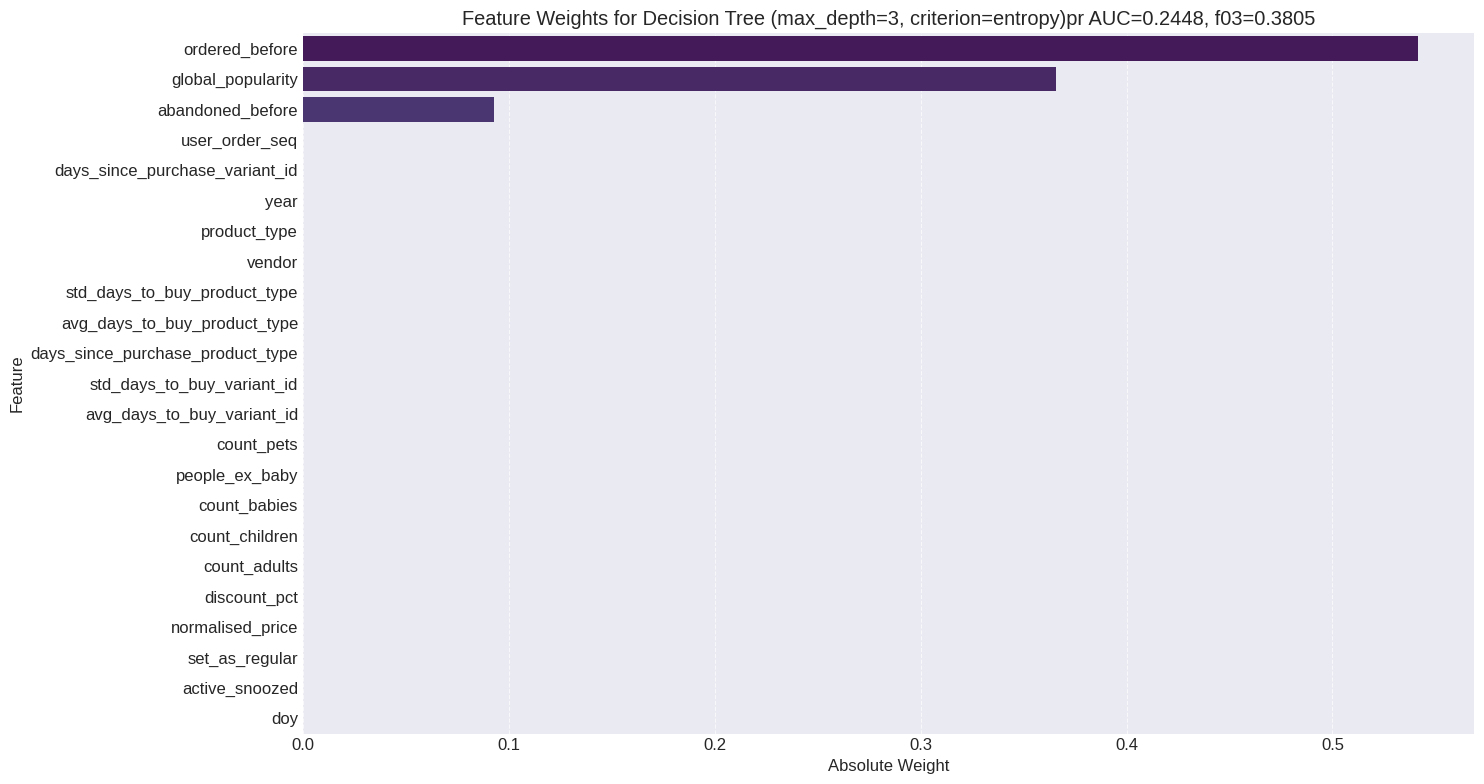

In [33]:
best_i = grid_results['pr_auc'].idxmax()
best_pipeline = grid_results['pipeline'][best_i]
best_model = best_pipeline.named_steps['model']
plot_model_weights(
    best_model,
    all_features_pro_names,
    model_name=f"Decision Tree "
                f"(max_depth={grid_results['max_depth'][best_i]}, "
                f"criterion={grid_results['criterion'][best_i]})"
                f"pr AUC={grid_results['pr_auc'][best_i]:.4f}, "
                f"f03={grid_results['f03_val'][best_i]:.4f}"
)

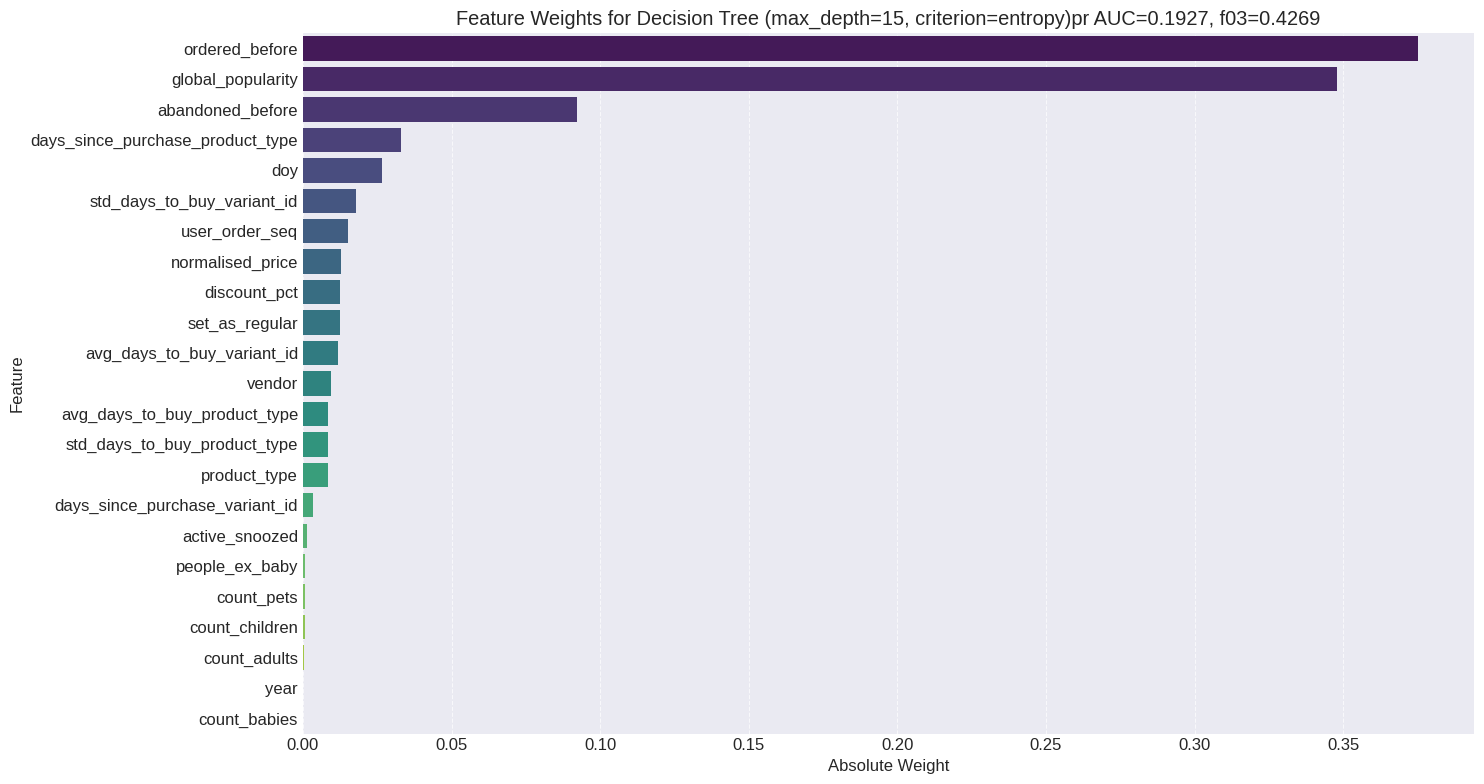

In [34]:
best_i = grid_results['f03_val'].idxmax()
best_pipeline = grid_results['pipeline'][best_i]
best_model = best_pipeline.named_steps['model']
plot_model_weights(
    best_model,
    all_features_pro_names,
    model_name=f"Decision Tree "
                f"(max_depth={grid_results['max_depth'][best_i]}, "
                f"criterion={grid_results['criterion'][best_i]})"
                f"pr AUC={grid_results['pr_auc'][best_i]:.4f}, "
                f"f03={grid_results['f03_val'][best_i]:.4f}"
)

## Random Forest

I will see what happens with a Random Forest with all numerical features.

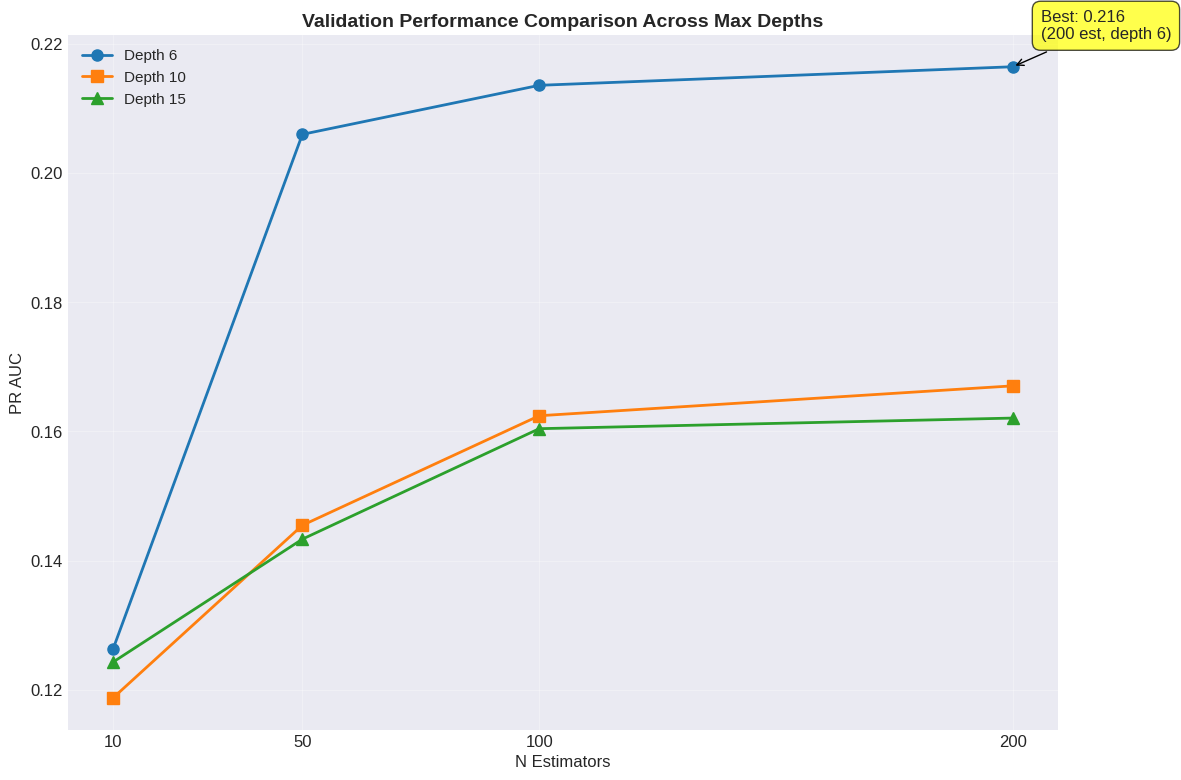


Best configuration: 200 estimators, max_depth=6 -> pr_auc: 0.2164 


In [ ]:
n_estimators_list = [10, 50, 100, 200]
max_depths = [6, 10, 15]

results = {}

for max_depth in max_depths:
    print(f"\nTesting max_depth = {max_depth}")
    print("-" * 40)
    
    pr_auc_scores = []
    roc_auc_scores = []
    f03_val_scores = []
    
    for n_estimators in n_estimators_list:
        print(f"Training Random Forest with {n_estimators} estimators, max_depth={max_depth}...")
        
        encoder = FrequencyEncoder()
        preprocessor = create_column_transformer(
            scale_numericals=False, categorical_transformer=encoder
        )
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                n_jobs=-1,
                random_state=random_state
            ))
        ])
        
        pipeline, roc_auc, pr_auc, f03_val, threshold = fit_and_evaluate_pipeline(
            pipeline, X_train, y_train,
            X_val, y_val
        )
        
        pr_auc_scores.append(pr_auc)
        roc_auc_scores.append(roc_auc)
        f03_val_scores.append(f03_val)
    
    results[max_depth] = {
        'roc_auc': roc_auc_scores,
        'pr_auc': pr_auc_scores,
        'val': f03_val_scores
    }

plt.figure(figsize=(12, 8))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']

for i, max_depth in enumerate(max_depths):
    depth_label = "Unlimited" if max_depth is None else f"Depth {max_depth}"
    plt.plot(n_estimators_list, results[max_depth]['pr_auc'], 
             color=colors[i], marker=markers[i], label=f'{depth_label}', 
             linewidth=2, markersize=8)

plt.xlabel('N Estimators', fontsize=12)
plt.ylabel('PR AUC', fontsize=12)
plt.title('Validation Performance Comparison Across Max Depths', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(n_estimators_list)

best_score = 0
best_config = None
for max_depth in max_depths:
    max_score = max(results[max_depth]['pr_auc'])
    if max_score > best_score:
        best_score = max_score
        best_idx = results[max_depth]['pr_auc'].index(max_score)
        best_config = (n_estimators_list[best_idx], max_depth)

if best_config:
    depth_label = "Unlimited" if best_config[1] is None else best_config[1]
    plt.annotate(f'Best: {best_score:.3f}\n({best_config[0]} est, depth {depth_label})', 
                xy=(best_config[0], best_score), xytext=(20, 20),
                textcoords='offset points', ha='left',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

print(f"\nBest configuration: {best_config[0]} estimators, max_depth={best_config[1]} -> pr_auc: {best_score:.4f} ")

So the best random forest model :
- ``n_estimators=200``
- ``max_depth=6``

Adding categorical features improves the f0.3 score in +0.634% and training time +9s.

## Boosting

In [34]:
!poetry add lightgbm

The following packages are already present in the pyproject.toml and will be skipped:

  - lightgbm

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


I'll try all numeric features + created_at feature preprocesing

I''l look for diferent learning rates and n_estimators (iterations) with free depth 

In [23]:
def lightgbm_grid_search(
        X_train, y_train, X_val, y_val,
        num_features,               
        n_trials,                
        param_space
    ) -> pd.DataFrame:

    keys, values = zip(*param_space.items())
    grid = [dict(zip(keys, v)) for v in itertools.product(*values)]
    random.Random(random_state).shuffle(grid)    # reproducible shuffle

    if n_trials < len(grid):
        grid = grid[:n_trials]         

    print(f"Grid search – {len(grid)} combos (budget = {n_trials})")
    print("=" * 60)

    records = []

    for idx, params in enumerate(grid, 1):
        params["random_state"] = random_state
        print(f"[{idx:02d}/{len(grid):02d}] "
              f"lr={params['learning_rate']:.3f}  "
              f"estim={params['n_estimators']:3d}")

        encoder = FrequencyEncoder(['vendor', 'product_type'])
        preprocessor = create_column_transformer(
            scale_numericals=False, categorical_transformer=encoder
        )

        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", LGBMClassifier(**params, n_jobs=-1))
        ])

        pipe, roc_auc, pr_auc, f03_val, threshold = fit_and_evaluate_pipeline(
            pipe, X_train, y_train, X_val, y_val)
        
        records.append({"learning_rate": params["learning_rate"],
                        "n_estimators" : params["n_estimators"],
                        "roc_auc"   : roc_auc,
                        "pr_auc"    : pr_auc,
                        "F0.3_val"     : f03_val,
                        "pipeline"  : pipe,
                        "Threshold"   : threshold})
        
    return pd.DataFrame(records)


param_space = {
    "num_leaves"        : [31],                
    "max_depth"         : [-1],                
    "learning_rate"     : [0.005, 0.01, 0.025, 0.05],
    "n_estimators"      : [50, 200, 500, 700],
    "min_child_samples" : [20],
    "subsample"         : [0.7],
    "colsample_bytree"  : [0.7],
}

results = lightgbm_grid_search(
        X_train, y_train, X_val, y_val,
        numeric_cols,   
        n_trials=100, 
        param_space=param_space)


Grid search – 16 combos (budget = 100)
[01/16] lr=0.005  estim= 50
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 1927962, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012286 -> initscore=-4.386930
[LightGBM] [Info] Start training from score -4.386930
   ⌛ Fitted in 5.03s
   🎯 ROC_AUC : 0.8552
   🎯 PR_AUC  : 0.2205
   🎯 F-beta  : 0.4350 (threshold=0.0895)
[02/16] lr=0.010  estim=500
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091047 seconds.
You can set `force_row_wise=true` to remove the overhead.
An

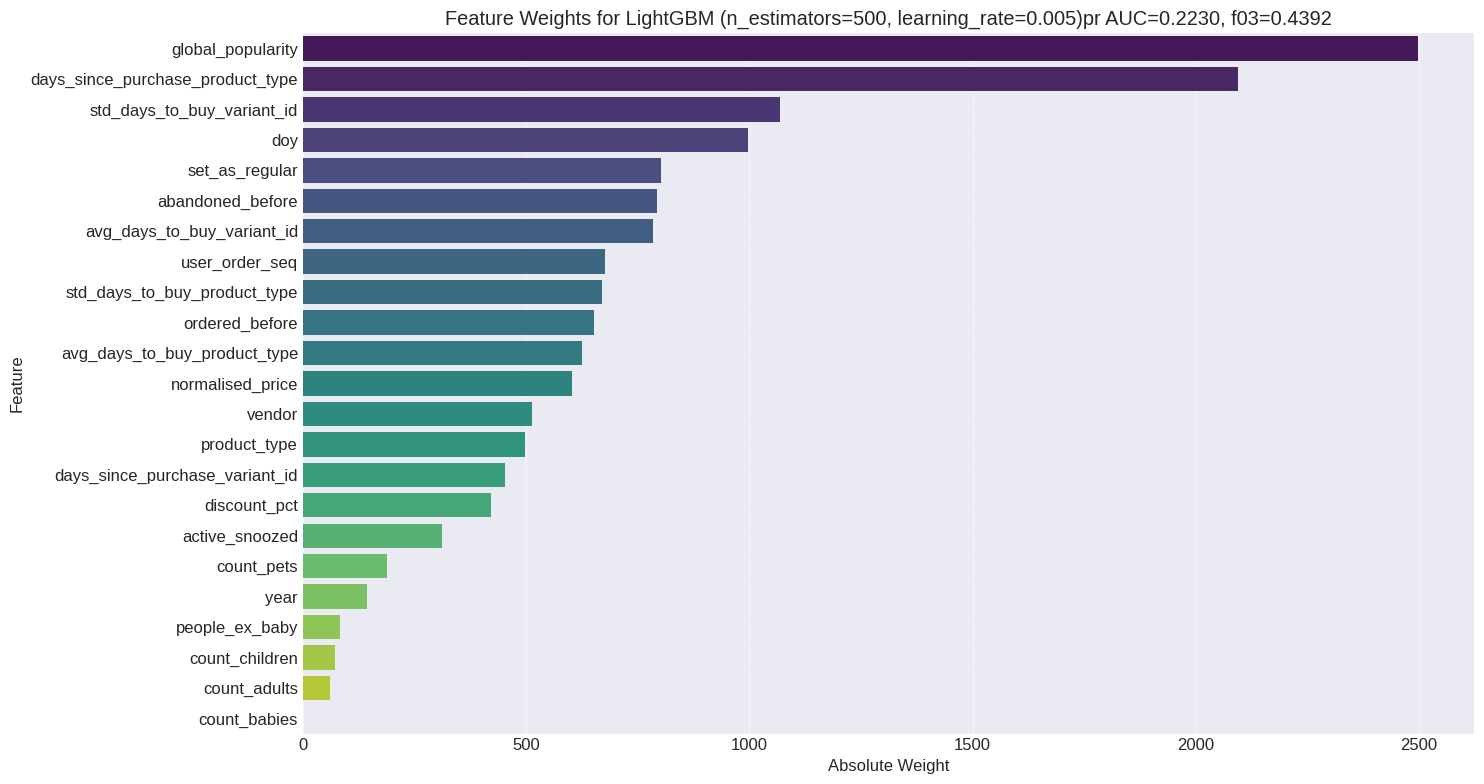

In [30]:
best_i = results['pr_auc'].idxmax()
best_pipeline = results['pipeline'][best_i]
best_model = best_pipeline.named_steps['model']
plot_model_weights(
    best_model,
    all_features_pro_names,
    model_name=f"LightGBM "
                f"(n_estimators={results['n_estimators'][best_i]}, "
                f"learning_rate={results['learning_rate'][best_i]})"
                f"pr AUC={results['pr_auc'][best_i]:.4f}, "
                f"f03={results['F0.3_val'][best_i]:.4f}"
)

I havn't found a better model 

## Neural Network Baseline

Lets see how NN works with this dataset. Will be a quick exploration

In [22]:
mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64, 32),     # two small dense layers
        activation="relu",
        solver="adam",
        alpha=1e-4,                      # L2 weight decay
        batch_size=256,                  # reasonable mini-batch for 2 M rows
        learning_rate_init=1e-3,
        max_iter=20,                     # keeps the test fast
        early_stopping=True,             # stops if val-loss stagnates
        n_iter_no_change=2,
        random_state=random_state,
        verbose=False
    ))
])

mlp_pipeline.fit(X_train[numeric_cols], y_train)

y_val_prob = mlp_pipeline.predict_proba(X_val[numeric_cols])[:, 1]
fpr, tpr, roc_auc, precision, recall, pr_auc = get_metrics(y_val, y_val_prob)

print(f"MLP ROC AUC: {roc_auc:.4f}")
print(f"MLP PR AUC: {pr_auc:.4f}")


MLP ROC AUC: 0.8474
MLP PR AUC: 0.2094


Lets compare diferente family models ROC and PR curves

In [23]:
def evaluate_pipeline(pipeline, X_val, y_val, model_name="Model"):
    y_val_prob = pipeline.predict_proba(X_val)[:, 1]
    
    fpr, tpr, roc_auc, precision, recall, pr_auc = get_metrics(y_val, y_val_prob)
    
    return {
        'name': model_name,
        'y_proba': y_val_prob,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'pr_auc': pr_auc
    }

In [24]:
linear_result = evaluate_pipeline(
    linear_baseline_pipeline, X_val, y_val, "Linear Baseline"
)

encoder = FrequencyEncoder()
preprocessor = create_column_transformer(
    scale_numericals=False, categorical_transformer=encoder
)

# Decision Tree Classifier
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(
        max_depth=15,
        criterion='entropy',
        min_samples_split=100,
        min_samples_leaf=40,
        random_state=random_state
    ))
])

dt_pipeline, _, _, _, _ = fit_and_evaluate_pipeline(
    dt_pipeline, X_train, y_train, X_val, y_val
)

decision_tree_result = evaluate_pipeline(
    dt_pipeline, X_val, y_val, "Decision Tree"
)

# Random Forest Classifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        n_jobs=-1,
        random_state=random_state
    ))
])

rf_pipeline, _, _, _, _ = fit_and_evaluate_pipeline(
    rf_pipeline, X_train, y_train, X_val, y_val
)

random_forest_result = evaluate_pipeline(
    rf_pipeline, X_val, y_val, "Random Forest"
)

# LightGBM Classifier
lightgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(
        n_estimators=500,
        learning_rate=0.005,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=20,
        subsample=0.7,
        colsample_bytree=0.7,
        random_state=random_state
    ))
])
lightgbm_pipeline, _, _, _, _ = fit_and_evaluate_pipeline(
    lightgbm_pipeline, X_train, y_train, X_val, y_val
)
lightgbm_result = evaluate_pipeline(
    lightgbm_pipeline, X_val, y_val, "LightGBM"
)

# MLP Classifier
mlp_result = evaluate_pipeline(
    mlp_pipeline, X_val[numeric_cols], y_val, "MLP"
)
results = [
    linear_result,
    decision_tree_result,
    random_forest_result,
    lightgbm_result,
    mlp_result
]


   ⌛ Fitted in 8.11s
   🎯 ROC_AUC : 0.7523
   🎯 PR_AUC  : 0.1165
   🎯 F-beta  : 0.2581 (threshold=0.5200)
   ⌛ Fitted in 57.79s
   🎯 ROC_AUC : 0.8478
   🎯 PR_AUC  : 0.2164
   🎯 F-beta  : 0.4407 (threshold=0.2356)
[LightGBM] [Info] Number of positive: 23687, number of negative: 1904275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1648
[LightGBM] [Info] Number of data points in the train set: 1927962, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.012286 -> initscore=-4.386930
[LightGBM] [Info] Start training from score -4.386930
   ⌛ Fitted in 27.42s
   🎯 ROC_AUC : 0.8602
   🎯 PR_AUC  : 0.2230
   🎯 F-beta  : 0.4392 (threshold=0.3039)


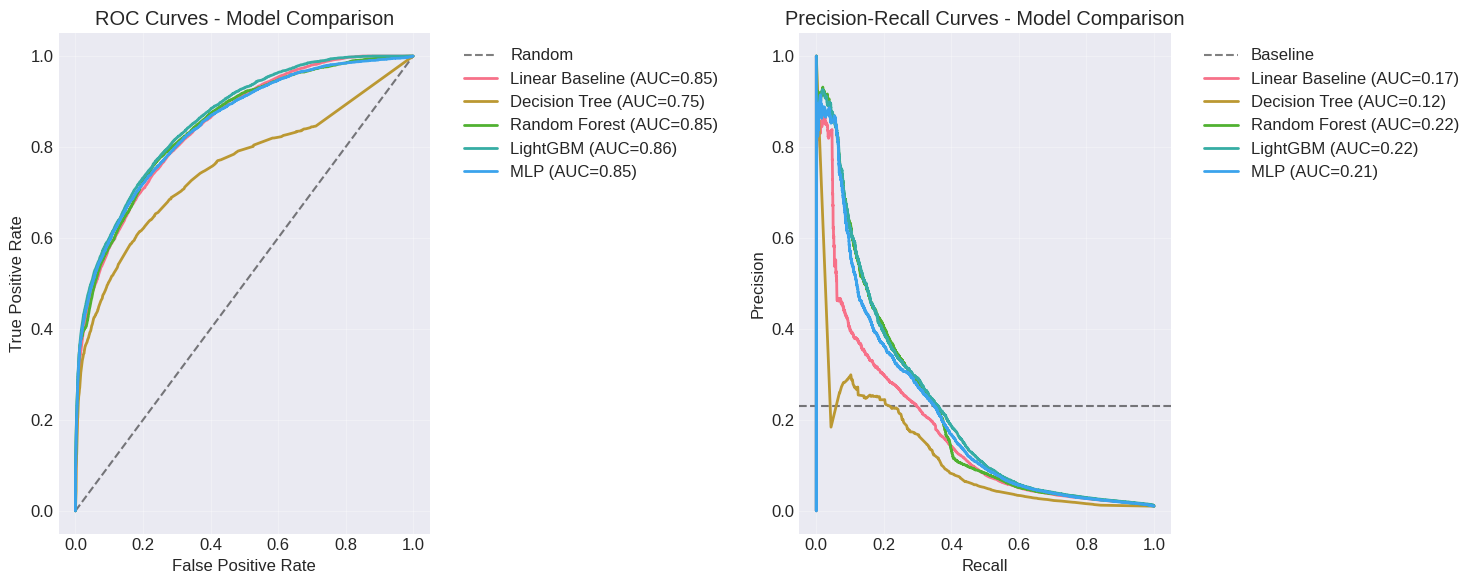

In [25]:
fig = plot_curves_comparison(results, title_suffix="- Model Comparison")
plt.show()

So the best model is GBM, and in that model we choose the threshold with most f03_score, which is a value we have defined in order to increase precision over recall.

In the e-commerce we have to avoid false positive, because the losses uninstalling the app against the profit of a single buyer are more significant